# Multivariate Analysis

In [1]:
from utils.feature_importance import feature_importance, metrics, summary_plot,multivariate_importance
from utils.plotting_functions import dual_heat_map
import joblib
from sklearn.pipeline import Pipeline
import optuna
from utils.Reg_Models import RegModels
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import load
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings # Ignore alert messages
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, TimeSeriesSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LassoLarsCV, LassoCV, Lasso

import xgboost as xgb
import eli5
from eli5.sklearn import PermutationImportance

from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import feature_importances
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv(r'C:\Users\DELL\Desktop\PG\df_nadal_clean.csv',sep=',')

In [3]:
def create_scaled_dataset(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=0,shuffle=False) 

    std_scaler = StandardScaler()
    X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
    X_scaled_test = pd.DataFrame(std_scaler.transform(X_test),columns=X_train.columns,index=X_test.index)
    return X_scaled_train,X_scaled_test, y_train,y_test

In [4]:
X, y = df[['CC_FL','CC_BL','AT_Y','CC_BR','CC_FR',
'AU_395_FR','AU_355_FL','AT_X','AT_Z']], df[['L/V_BL']]
X_train_scaled,X_test_scaled,y_train,y_test = create_scaled_dataset(X,y)

## Distribuição dados Treino x Teste para essa distribuição

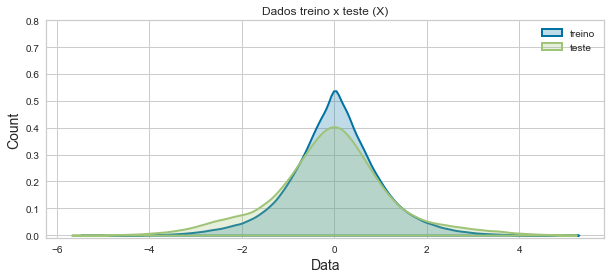

In [13]:
plt.figure(figsize=(10,4))
sns.distplot(X_train_scaled, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'treino')
sns.distplot(X_test_scaled, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'teste')
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Dados treino x teste (X)")
plt.ylim([-0.01,0.8])
plt.legend(loc='upper right')

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


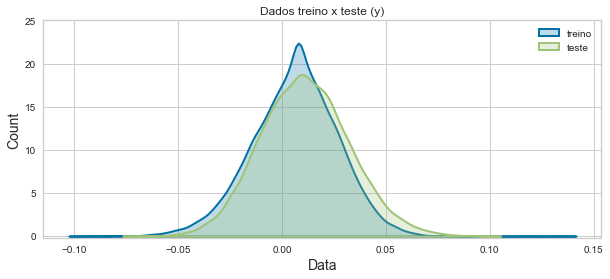

In [7]:
plt.figure(figsize=(10,4))
sns.distplot(y_train, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'treino')
sns.distplot(y_test, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'teste')
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Dados treino x teste (y)")
plt.ylim([-0.2,25])
plt.legend(loc='upper right')

A distribuição parece ser representativa, podemos seguir em frente

In [5]:
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import numpy as np
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from yellowbrick.model_selection import feature_importances
import xgboost as xgb
from sklearn.linear_model import ElasticNet
import eli5
from tqdm import tqdm
from eli5.sklearn import PermutationImportance



def summary_plot(model,X_train,y_train,X_test,y_test,cv,train_sizes=np.linspace(0.1,1.0,5),lc=False):

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
    plt.rc('legend',fontsize=12.5) 


    visualize_residuals = residuals_plot(model,X_train, y_train, X_test, y_test,show=False,ax=ax[0],title=' ');
    ax[0].tick_params(labelsize=13)
    ax[0].set_xlabel('Predicted value (mm)',fontsize=16)
    ax[0].set_ylabel('Residuals (mm)',fontsize=16)

    visualizer = prediction_error(model, X_test, y_test, show=False, ax=ax[1], title=' ')
    ax[1].tick_params(labelsize=13)
    ax[1].set_xlabel('Predicted value (mm)',fontsize=16)
    ax[1].set_ylabel('Real value (mm)',fontsize=16)

    if lc:
        print('Plotting learning curves')
        visual_LC = learning_curve(model, X_train, y_train,scoring='r2',cv=cv,ax=ax[2],title=' ',show=False,train_sizes=train_sizes,n_jobs=-1);
        ax[2].set_ylim([0.6, 1.05])
        ax[2].tick_params(labelsize=13)
        ax[2].set_xlabel('Number of training instances',fontsize=16)
        ax[2].set_ylabel(r'$R^2$' + ' metric',fontsize=16)
        
    plt.show()
    
    return


def metrics(y_test,predict):
    
    mse = mean_squared_error(y_test,predict)
    mae= mean_absolute_error(y_test,predict)
    r2= r2_score(y_test,predict)
    return print("MSE:{}".format(mse),"\nMAE:{}".format(mae),"\nR2:{}".format(r2))


def feature_importance(X_train,y_train,X_test,y_test,relative=True,topn=9):
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10),sharex=True)
    plt.rc('legend',fontsize=12.5) 

    ################################################################
    # Lasso Regression
    ################################################################
    
    mod = Lasso(alpha=0.001)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    viz1 = FeatureImportances(Lasso(alpha=0.001),relative=relative,topn=topn, title =' ',ax=ax[0,0],absolute=True)
    viz1.fit(X_train,y_train)
    ax[0,0].tick_params(labelsize=13)
    ax[0,0].set_title('Lasso Regression - R^2 = {}'.format(r2),fontsize=20)

    ################################################################

    mod = RandomForestRegressor(**study_rf.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    rfr = RandomForestRegressor(**study_rf.best_params,random_state=2020)
    viz2 = FeatureImportances(rfr,relative=relative, topn=topn, title =' ',ax=ax[0,1])
    viz2.fit(X_train,y_train)
    ax[0,1].tick_params(labelsize=13)
    ax[0,1].set_title('RandomForestRegressor - R^2 = {}'.format(r2),fontsize=20)
    
    ################################################################

    mod = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    abr = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
    viz3 = FeatureImportances(abr,relative=relative, topn=topn, title =' ', ax=ax[1,0])
    viz3.fit(X_train,y_train)
    ax[1,0].tick_params(labelsize=13)
    ax[1,0].set_xlabel('Relative feature importance',fontsize=16)
    ax[1,0].set_title('XGBoostRegressor - R^2 = {}'.format(r2),fontsize=20)
  
    ################################################################
    
    mod = ElasticNet(**study_en.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    gbr = ElasticNet(**study_en.best_params,random_state=2020)
    viz4 = FeatureImportances(gbr,relative=relative, topn=topn, title =' ',ax=ax[1,1])
    viz4.fit(X_train,y_train)
    ax[1,1].tick_params(labelsize=13)
    ax[1,1].set_xlabel('Relative feature importance',fontsize=16)
    ax[1,1].set_title('ElasticNet - R^2 = {}'.format(r2),fontsize=20)

    plt.tight_layout()
    plt.show()
    
    return


class multivariate_importance():
    def __init__(self, X_train, X_test, y_train, y_test, nmodels=6):

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.nmodels = nmodels

        mod1 = Lasso(alpha=0.001)
        mod2 = RandomForestRegressor(**study_rf.best_params,random_state=2020)
        mod3 = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
        mod4 = GradientBoostingRegressor(random_state=0)
        mod5 = ExtraTreesRegressor(random_state=0, n_jobs=-1)
        mod6 = ElasticNet(**study_en.best_params,random_state=2020)

        self.mod_list = [mod1, mod2,
                         mod3, mod4,
                         mod5, mod6]

        self.mod_list = self.mod_list[0:self.nmodels]

        self.model_r2 = None

        print('All models for determining feature importance')
        print(self.mod_list)
        print('')

    def train_models(self):

        model_r2 = []
        for model in tqdm(self.mod_list):
            model.fit(self.X_train, self.y_train)
            model_r2.append(np.round(r2_score(self.y_test, model.predict(self.X_test)), 4))

        self.model_r2 = model_r2

        return model_r2

    def permutation_importance(self, model_index=1):

        self.mod_list[model_index].fit(self.X_train, self.y_train)
        perm = PermutationImportance(self.mod_list[model_index], random_state=1).fit(
            self.X_train, self.y_train)
        return eli5.show_weights(perm, feature_names=X_train.columns.tolist())

    def plot(self, relative=True, topn=9, absolute=True, plot_R2=True):

        fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 18))

        if self.model_r2 == None:
            print('Obtaining R2 score for all 6 models')
            multivariate_importance.train_models(self)
            print('R2 score calculated')

        print('Obtaining feature importance - 0%')
        viz1 = FeatureImportances(self.mod_list[0], relative=relative, topn=topn, ax=ax[0, 0], absolute=absolute)
        viz1.fit(self.X_train, self.y_train)
        ax[0, 0].tick_params(labelsize=16)

        viz2 = FeatureImportances(self.mod_list[1], relative=relative, topn=topn, ax=ax[0, 1], absolute=absolute)
        viz2.fit(self.X_train, self.y_train)
        ax[0, 1].tick_params(labelsize=16)

        viz3 = FeatureImportances(self.mod_list[2], relative=relative, topn=topn, ax=ax[0, 2], absolute=absolute)
        viz3.fit(self.X_train, self.y_train)
        ax[0, 2].tick_params(labelsize=18)
        print('Obtaining feature importance - 50%')
        viz4 = FeatureImportances(self.mod_list[3], relative=relative, topn=topn, ax=ax[1, 0], absolute=absolute)
        viz4.fit(self.X_train, self.y_train)
        ax[1, 0].tick_params(labelsize=18)

        viz5 = FeatureImportances(self.mod_list[4], relative=relative, topn=topn, ax=ax[1, 1], absolute=absolute)
        viz5.fit(self.X_train, self.y_train)
        ax[1, 1].tick_params(labelsize=18)

        viz6 = FeatureImportances(self.mod_list[5], relative=relative, topn=topn, ax=ax[1, 2], absolute=absolute)
        viz6.fit(self.X_train, self.y_train)
        ax[1, 2].tick_params(labelsize=18)
        print('Obtaining feature importance - 100%')

        if plot_R2:

            ax[0, 0].set_title(
                'Lasso Regression - $R^2$ = {}'.format(self.model_r2[0]), fontsize=25)
            ax[0, 1].set_title(
                'RandomForestRegressor - $R^2$ = {}'.format(self.model_r2[1]), fontsize=25)
            ax[0, 2].set_title(
                'XGBoostRegressor - $R^2$ = {}'.format(self.model_r2[2]), fontsize=25)
            ax[1, 0].set_title(
                'GradientBoostingRegressor - $R^2$ = {}'.format(self.model_r2[3]), fontsize=25)
            ax[1, 1].set_title(
                'ExtraTreesRegressor - $R^2$ = {}'.format(self.model_r2[4]), fontsize=25)
            ax[1, 2].set_title(
                'ElasticNet - $R^2$ = {}'.format(self.model_r2[5]), fontsize=25)

            ax[0, 0].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 1].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 2].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 0].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 1].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 2].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 0].set_xlim([0,0.1])
            #ax[0, 1].set_xlim([0,0.5])
            #ax[0, 2].set_xlim([0,0.5])
            #ax[1, 0].set_xlim([0,0.5])
            #ax[1, 1].set_xlim([0,0.5])
            ax[1, 2].set_xlim([0,0.1])

        plt.tight_layout()
        return


In [8]:
study_rf = joblib.load("study_RandomForest_B.pkl")
study_ab = joblib.load("study_AdaBost_B.pkl")
study_en = joblib.load("study_ElasticNet_B.pkl")
study_xgb = joblib.load("study_XGBoost.pkl")


All models for determining feature importance
[Lasso(alpha=0.001), RandomForestRegressor(max_depth=36, max_features=5, min_samples_leaf=5,
                      min_samples_split=11, n_estimators=375,
                      random_state=2020), XGBRegressor(alpha=0.02111400159780091, base_score=None, booster=None,
             colsample_bylevel=0.9000000000000001, colsample_bynode=1.0,
             colsample_bytree=0.6000000000000001, enable_categorical=False,
             gamma=None, gpu_id=None, importance_type=None,
             interaction_constraints=None, lambda=0.001530808845481313,
             learning_rate=None, max_delta_step=None, max_depth=10,
             min_child_weight=7.1, min_split_loss=0.0027632330369892592,
             missing=nan, monotone_constraints=None, n_estimators=5850,
             n_jobs=None, num_parallel_tree=None, predictor=None,
             random_state=2020, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.7000000000000

 17%|█▋        | 1/6 [00:00<00:01,  3.36it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\1229660262.py:150: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(self.X_train, self.y_train)
 33%|███▎      | 2/6 [01:17<03:01, 45.42s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 50%|█████     | 3/6 [07:39<09:57, 199.29s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 67%|██████▋   | 4/6 [07:55<0

R2 score calculated
Obtaining feature importance - 0%
Obtaining feature importance - 50%
Obtaining feature importance - 100%


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


CPU times: total: 20min 43s
Wall time: 8min 24s


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

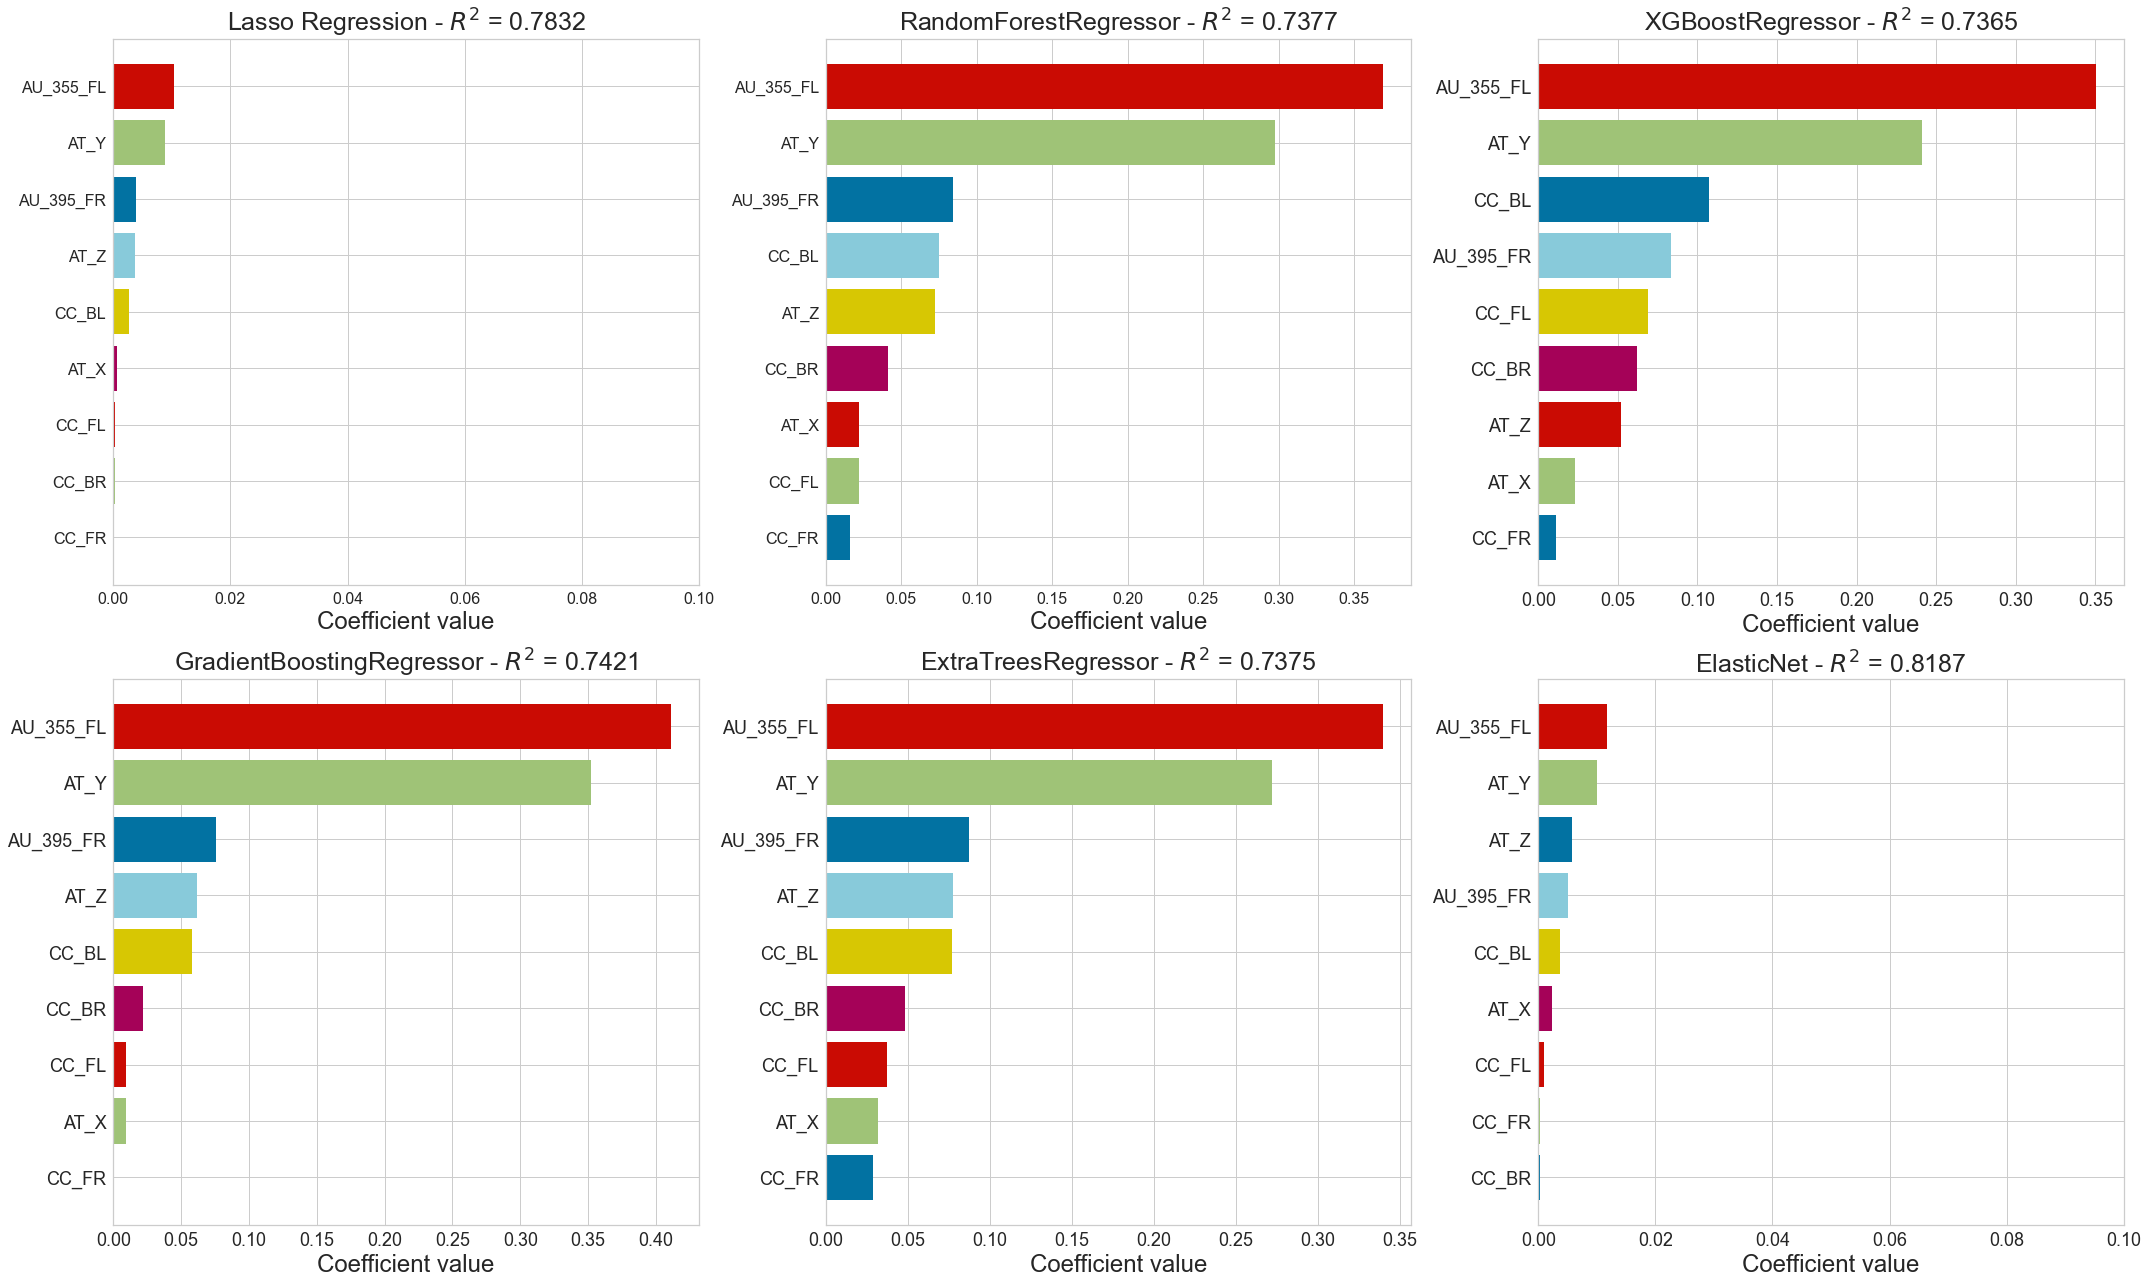

In [9]:
%%time
multi_select = multivariate_importance(X_train_scaled,X_test_scaled,y_train,y_test)     
multi_select.plot(relative=False)
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

np.seterr(divide='ignore')

# Optuna study

In [10]:
#X, y = df_nadal[['CC_FR', 'CC_FL', 'CC_BR', 'CC_BL','AT_Y',
#'AU_395_FR','AU_395_FL','AU_275_FR','AU_275_FL']], df_nadal[['L/V_FR']]
#X_train_scaled,X_test_scaled,y_train,y_test = create_scaled_dataset(X,y)

### Random Forest - FR

In [11]:
import optuna

def objective(trial):
    
    joblib.dump(study, 'study.pkl')
    
    f_n_estimators = trial.suggest_int("n_estimators", low=200,high=1000,step=25)
    f_max_depth = trial.suggest_int("max_depth", low=2,high=50,step=2)
    f_min_samples_leaf = trial.suggest_int("min_samples_leaf", low=1, high=20, step=1)
    f_min_samples_split = trial.suggest_int("min_samples_split", low=2, high=20, step=1)
    int_max_features = np.arange(2,len(X_train_scaled.columns),1,dtype=int) 
    max_features_list = []
    for e in int_max_features: 
       max_features_list.append(int(e))
    f_max_features = trial.suggest_categorical("max_features",max_features_list) 
     
    model = RandomForestRegressor(max_depth=f_max_depth,
                                           n_estimators = f_n_estimators,
                                           min_samples_split = f_min_samples_split,
                                           min_samples_leaf = f_min_samples_leaf,
                                           max_features = f_max_features,
                                           random_state=0, 
                                           n_jobs = -1)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study = optuna.create_study(direction='maximize')

[I 2022-12-05 11:04:11,050] A new study created in memory with name: no-name-290848f8-0652-42f6-ac4e-d221513eccfe


In [12]:
study.optimize(objective, n_trials=20,show_progress_bar=True)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 11:04:35,056] Trial 0 finished with value: 0.6914829398645221 and parameters: {'n_estimators': 575, 'max_depth': 18, 'min_samples_leaf': 13, 'min_samples_split': 4, 'max_features': 2}. Best is trial 0 with value: 0.6914829398645221.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 11:05:34,424] Trial 1 finished with value: 0.7317717803397124 and parameters: {'n_estimators': 650, 'max_depth': 28, 'min_samples_leaf': 16, 'min_samples_split': 16, 'max_features': 6}. Best is trial 1 with value: 0.7317717803397124.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 11:06:04,512] Trial 2 finished with value: 0.728952580007669 and parameters: {'n_estimators': 300, 'max_depth': 42, 'min_samples_leaf': 20, 'min_samples_split': 7, 'max_features': 7}. Best is trial 1 with value: 0.7317717803397124.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 11:06:12,137] Trial 3 finished with value: 0.6852562544303344 and parameters: {'n_estimators': 200, 'max_depth': 46, 'min_samples_leaf': 16, 'min_samples_split': 3, 'max_features': 2}. Best is trial 1 with value: 0.7317717803397124.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 11:07:02,826] Trial 4 finished with value: 0.7271395061656929 and parameters: {'n_estimators': 675, 'max_depth': 34, 'min_samples_leaf': 19, 'min_samples_split': 17, 'max_features': 5}. Best is trial 1 with value: 0.7317717803397124.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 11:07:56,302] Trial 5 finished with value: 0.7391925947763067 and parameters: {'n_estimators': 475, 'max_depth': 42, 'min_samples_leaf': 1, 'min_samples_split': 12, 'max_features': 6}. Best is trial 5 with value: 0.7391925947763067.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 11:08:59,904] Trial 6 finished with value: 0.7332260194348496 and parameters: {'n_estimators': 700, 'max_depth': 46, 'min_samples_leaf': 12, 'min_samples_split': 9, 'max_features': 5}. Best is trial 5 with value: 0.7391925947763067.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 11:09:27,516] Trial 7 finished with value: 0.7375150489092225 and parameters: {'n_estimators': 225, 'max_depth': 30, 'min_samples_leaf': 9, 'min_samples_split': 5, 'max_features': 8}. Best is trial 5 with value: 0.7391925947763067.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 11:10:26,374] Trial 8 finished with value: 0.7311233788519307 and parameters: {'n_estimators': 650, 'max_depth': 48, 'min_samples_leaf': 17, 'min_samples_split': 14, 'max_features': 6}. Best is trial 5 with value: 0.7391925947763067.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 11:11:27,626] Trial 9 finished with value: 0.7286173103369196 and parameters: {'n_estimators': 800, 'max_depth': 32, 'min_samples_leaf': 14, 'min_samples_split': 16, 'max_features': 4}. Best is trial 5 with value: 0.7391925947763067.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 11:11:49,252] Trial 10 finished with value: 0.7133594713255246 and parameters: {'n_estimators': 425, 'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 20, 'max_features': 3}. Best is trial 5 with value: 0.7391925947763067.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 11:12:42,002] Trial 11 finished with value: 0.7384754208945394 and parameters: {'n_estimators': 425, 'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 11, 'max_features': 8}. Best is trial 5 with value: 0.7391925947763067.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 11:13:06,788] Trial 12 finished with value: 0.4917632365807758 and parameters: {'n_estimators': 450, 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 12, 'max_features': 8}. Best is trial 5 with value: 0.7391925947763067.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 11:14:04,662] Trial 13 finished with value: 0.73869198345288 and parameters: {'n_estimators': 450, 'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 11, 'max_features': 8}. Best is trial 5 with value: 0.7391925947763067.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 11:15:43,590] Trial 14 finished with value: 0.7393913585040818 and parameters: {'n_estimators': 925, 'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 9, 'max_features': 6}. Best is trial 14 with value: 0.7393913585040818.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 11:17:18,555] Trial 15 finished with value: 0.7386791795797164 and parameters: {'n_estimators': 1000, 'max_depth': 38, 'min_samples_leaf': 5, 'min_samples_split': 8, 'max_features': 6}. Best is trial 14 with value: 0.7393913585040818.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 11:18:30,024] Trial 16 finished with value: 0.7160530332986986 and parameters: {'n_estimators': 975, 'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 13, 'max_features': 6}. Best is trial 14 with value: 0.7393913585040818.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 11:20:20,941] Trial 17 finished with value: 0.7384956761152981 and parameters: {'n_estimators': 875, 'max_depth': 24, 'min_samples_leaf': 1, 'min_samples_split': 6, 'max_features': 6}. Best is trial 14 with value: 0.7393913585040818.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 11:20:55,949] Trial 18 finished with value: 0.7254242622233507 and parameters: {'n_estimators': 550, 'max_depth': 40, 'min_samples_leaf': 4, 'min_samples_split': 9, 'max_features': 3}. Best is trial 14 with value: 0.7393913585040818.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 11:21:51,222] Trial 19 finished with value: 0.7242041576640535 and parameters: {'n_estimators': 800, 'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 2, 'max_features': 4}. Best is trial 14 with value: 0.7393913585040818.
Accuracy: 0.7393913585040818
Best hyperparameters: {'n_estimators': 925, 'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 9, 'max_features': 6}


In [13]:
joblib.dump(study, "study_RandomForest_BL.pkl")

['study_RandomForest_BL.pkl']

In [14]:
study.best_trial

FrozenTrial(number=14, values=[0.7393913585040818], datetime_start=datetime.datetime(2022, 12, 5, 11, 14, 4, 666052), datetime_complete=datetime.datetime(2022, 12, 5, 11, 15, 43, 589568), params={'n_estimators': 925, 'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 9, 'max_features': 6}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=200, step=25), 'max_depth': IntDistribution(high=50, log=False, low=2, step=2), 'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1), 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 'max_features': CategoricalDistribution(choices=(2, 3, 4, 5, 6, 7, 8))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=14, state=TrialState.COMPLETE, value=None)

In [15]:
optuna.visualization.plot_optimization_history(study)

In [16]:
optuna.visualization.plot_slice(study)

### Extra-Trees Regressor

In [17]:
from sklearn.ensemble import ExtraTreesRegressor

def objective(trial):
    
        
    param = {
        'n_estimators': trial.suggest_int('n_estimators',200,800,25),
        'max_depth': trial.suggest_int('max_depth',2,20,2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,10,1),
        'random_state': 2020,
        #'max_leaf_nodes': trial.suggest_int('max_leaf_nodes',1,1000,25),
       
        'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf',0.0,0.2,step=0.01),
    
    }
    
    model = ExtraTreesRegressor(**param)    
  
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_ext = optuna.create_study(direction='maximize')

[I 2022-12-05 11:21:53,416] A new study created in memory with name: no-name-a8aad79e-e65c-40a7-a0f7-7967acfd5463


In [18]:
study_ext.optimize(objective, n_trials=100,show_progress_bar=True)

trial_ext = study_ext.best_trial

print('Accuracy: {}'.format(trial_ext.value))
print("Best hyperparameters: {}".format(trial_ext.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:22:01,969] Trial 0 finished with value: 0.31933557807988666 and parameters: {'n_estimators': 600, 'max_depth': 8, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.08}. Best is trial 0 with value: 0.31933557807988666.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:22:04,777] Trial 1 finished with value: 0.20225119111189271 and parameters: {'n_estimators': 325, 'max_depth': 4, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.14}. Best is trial 0 with value: 0.31933557807988666.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:22:09,809] Trial 2 finished with value: 0.5330151395533534 and parameters: {'n_estimators': 200, 'max_depth': 16, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.02}. Best is trial 2 with value: 0.5330151395533534.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:22:18,480] Trial 3 finished with value: 0.4450055369813446 and parameters: {'n_estimators': 525, 'max_depth': 16, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.04}. Best is trial 2 with value: 0.5330151395533534.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:22:21,284] Trial 4 finished with value: 0.25458187165281454 and parameters: {'n_estimators': 325, 'max_depth': 18, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.11}. Best is trial 2 with value: 0.5330151395533534.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:22:25,929] Trial 5 finished with value: 0.13502918267855968 and parameters: {'n_estimators': 775, 'max_depth': 18, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.18}. Best is trial 2 with value: 0.5330151395533534.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:22:37,053] Trial 6 finished with value: 0.48973664729767175 and parameters: {'n_estimators': 625, 'max_depth': 18, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.03}. Best is trial 2 with value: 0.5330151395533534.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:22:38,626] Trial 7 finished with value: 0.24409759619340032 and parameters: {'n_estimators': 225, 'max_depth': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.03}. Best is trial 2 with value: 0.5330151395533534.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:22:41,131] Trial 8 finished with value: 0.1302963677180492 and parameters: {'n_estimators': 400, 'max_depth': 14, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.18}. Best is trial 2 with value: 0.5330151395533534.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:22:48,607] Trial 9 finished with value: 0.37887953517627615 and parameters: {'n_estimators': 575, 'max_depth': 12, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.06}. Best is trial 2 with value: 0.5330151395533534.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:22:53,675] Trial 10 finished with value: 0.5683188744987879 and parameters: {'n_estimators': 200, 'max_depth': 8, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.01}. Best is trial 10 with value: 0.5683188744987879.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:22:59,692] Trial 11 finished with value: 0.5848025147280975 and parameters: {'n_estimators': 200, 'max_depth': 8, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0}. Best is trial 11 with value: 0.5848025147280975.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:23:08,727] Trial 12 finished with value: 0.5884579130781027 and parameters: {'n_estimators': 300, 'max_depth': 8, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0}. Best is trial 12 with value: 0.5884579130781027.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:23:19,111] Trial 13 finished with value: 0.5915908159807978 and parameters: {'n_estimators': 400, 'max_depth': 8, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.5915908159807978.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:23:24,151] Trial 14 finished with value: 0.37202721024270513 and parameters: {'n_estimators': 425, 'max_depth': 6, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.06}. Best is trial 13 with value: 0.5915908159807978.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:23:26,858] Trial 15 finished with value: 0.25458187165281454 and parameters: {'n_estimators': 325, 'max_depth': 10, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.11}. Best is trial 13 with value: 0.5915908159807978.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:23:44,129] Trial 16 finished with value: 0.6871965527819811 and parameters: {'n_estimators': 425, 'max_depth': 12, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:23:50,143] Trial 17 finished with value: 0.40942773813326827 and parameters: {'n_estimators': 450, 'max_depth': 12, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.05}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:23:56,997] Trial 18 finished with value: 0.3167841862524873 and parameters: {'n_estimators': 675, 'max_depth': 14, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.08}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:24:00,434] Trial 19 finished with value: 0.1749564683482303 and parameters: {'n_estimators': 500, 'max_depth': 4, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.15}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:24:04,538] Trial 20 finished with value: 0.31738425100705425 and parameters: {'n_estimators': 400, 'max_depth': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.08}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:24:09,637] Trial 21 finished with value: 0.5139307284417752 and parameters: {'n_estimators': 275, 'max_depth': 6, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:24:17,775] Trial 22 finished with value: 0.5801919429492862 and parameters: {'n_estimators': 350, 'max_depth': 10, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.01}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:24:26,273] Trial 23 finished with value: 0.5143729540931323 and parameters: {'n_estimators': 475, 'max_depth': 6, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.0}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:24:31,708] Trial 24 finished with value: 0.5315067465704465 and parameters: {'n_estimators': 275, 'max_depth': 12, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.02}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:24:37,470] Trial 25 finished with value: 0.4463365128762373 and parameters: {'n_estimators': 375, 'max_depth': 8, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.04}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:24:43,563] Trial 26 finished with value: 0.5311753243472249 and parameters: {'n_estimators': 275, 'max_depth': 14, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.02}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:24:51,018] Trial 27 finished with value: 0.4037327251039047 and parameters: {'n_estimators': 550, 'max_depth': 4, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:24:56,736] Trial 28 finished with value: 0.373345467218582 and parameters: {'n_estimators': 450, 'max_depth': 20, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.06}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:25:00,407] Trial 29 finished with value: 0.2934023899994259 and parameters: {'n_estimators': 375, 'max_depth': 10, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.09}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:25:04,289] Trial 30 finished with value: 0.4437325554653495 and parameters: {'n_estimators': 275, 'max_depth': 6, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.04}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:25:10,512] Trial 31 finished with value: 0.586857095895321 and parameters: {'n_estimators': 250, 'max_depth': 8, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:25:15,785] Trial 32 finished with value: 0.5689346418880397 and parameters: {'n_estimators': 250, 'max_depth': 8, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.01}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:25:22,379] Trial 33 finished with value: 0.52327484448515 and parameters: {'n_estimators': 325, 'max_depth': 8, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.02}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:25:24,361] Trial 34 finished with value: 0.24126799522676978 and parameters: {'n_estimators': 300, 'max_depth': 2, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.03}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:25:26,457] Trial 35 finished with value: 0.10074557246905236 and parameters: {'n_estimators': 375, 'max_depth': 10, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.2}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:25:31,748] Trial 36 finished with value: 0.4098236244526202 and parameters: {'n_estimators': 425, 'max_depth': 4, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.01}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:25:35,261] Trial 37 finished with value: 0.19581719130224995 and parameters: {'n_estimators': 500, 'max_depth': 12, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.14}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:25:40,150] Trial 38 finished with value: 0.4696251207891162 and parameters: {'n_estimators': 325, 'max_depth': 6, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.03}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:25:50,755] Trial 39 finished with value: 0.4169716977927449 and parameters: {'n_estimators': 800, 'max_depth': 8, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.05}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:25:55,189] Trial 40 finished with value: 0.5345788371065863 and parameters: {'n_estimators': 225, 'max_depth': 14, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.02}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:26:00,470] Trial 41 finished with value: 0.5848025147280975 and parameters: {'n_estimators': 200, 'max_depth': 8, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:26:06,187] Trial 42 finished with value: 0.5901851523517299 and parameters: {'n_estimators': 225, 'max_depth': 8, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:26:12,068] Trial 43 finished with value: 0.5852108572210868 and parameters: {'n_estimators': 250, 'max_depth': 10, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.01}. Best is trial 16 with value: 0.6871965527819811.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:26:24,975] Trial 44 finished with value: 0.7215145842993824 and parameters: {'n_estimators': 225, 'max_depth': 16, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:26:29,454] Trial 45 finished with value: 0.5345788371065863 and parameters: {'n_estimators': 225, 'max_depth': 16, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.02}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:26:34,521] Trial 46 finished with value: 0.4922049410549113 and parameters: {'n_estimators': 300, 'max_depth': 16, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.03}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:26:39,687] Trial 47 finished with value: 0.4494010726285197 and parameters: {'n_estimators': 350, 'max_depth': 20, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.04}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:26:54,809] Trial 48 finished with value: 0.5839838791329007 and parameters: {'n_estimators': 625, 'max_depth': 18, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.01}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:27:00,430] Trial 49 finished with value: 0.2273079454407836 and parameters: {'n_estimators': 725, 'max_depth': 12, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.12}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:27:20,939] Trial 50 finished with value: 0.7090094054101859 and parameters: {'n_estimators': 425, 'max_depth': 14, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:27:41,492] Trial 51 finished with value: 0.7090094054101859 and parameters: {'n_estimators': 425, 'max_depth': 14, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:27:51,799] Trial 52 finished with value: 0.5837084550685823 and parameters: {'n_estimators': 425, 'max_depth': 14, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.01}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:28:18,292] Trial 53 finished with value: 0.7198707836801033 and parameters: {'n_estimators': 475, 'max_depth': 16, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:28:29,943] Trial 54 finished with value: 0.5844206914910995 and parameters: {'n_estimators': 475, 'max_depth': 16, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.01}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:28:38,728] Trial 55 finished with value: 0.48838013124725876 and parameters: {'n_estimators': 525, 'max_depth': 18, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.03}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:28:47,535] Trial 56 finished with value: 0.5248857793184732 and parameters: {'n_estimators': 450, 'max_depth': 14, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.02}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:29:19,293] Trial 57 finished with value: 0.7197964468349036 and parameters: {'n_estimators': 550, 'max_depth': 16, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:29:22,941] Trial 58 finished with value: 0.15797642351678232 and parameters: {'n_estimators': 550, 'max_depth': 16, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.16}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:29:30,940] Trial 59 finished with value: 0.414264398895242 and parameters: {'n_estimators': 600, 'max_depth': 18, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.05}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:29:59,592] Trial 60 finished with value: 0.718615224222032 and parameters: {'n_estimators': 525, 'max_depth': 16, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:30:29,200] Trial 61 finished with value: 0.7187514830805917 and parameters: {'n_estimators': 550, 'max_depth': 16, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:30:59,931] Trial 62 finished with value: 0.7174160797037441 and parameters: {'n_estimators': 575, 'max_depth': 16, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:31:11,342] Trial 63 finished with value: 0.5271703074527905 and parameters: {'n_estimators': 575, 'max_depth': 16, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.02}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:31:27,272] Trial 64 finished with value: 0.5831586488083845 and parameters: {'n_estimators': 525, 'max_depth': 18, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.01}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:32:04,444] Trial 65 finished with value: 0.7185467180712923 and parameters: {'n_estimators': 650, 'max_depth': 16, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:32:45,143] Trial 66 finished with value: 0.7185467180712923 and parameters: {'n_estimators': 650, 'max_depth': 16, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:33:05,984] Trial 67 finished with value: 0.5841547776697076 and parameters: {'n_estimators': 700, 'max_depth': 20, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.01}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:33:19,424] Trial 68 finished with value: 0.49044335405078976 and parameters: {'n_estimators': 650, 'max_depth': 18, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.03}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:33:36,051] Trial 69 finished with value: 0.530617807815061 and parameters: {'n_estimators': 750, 'max_depth': 16, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.02}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:33:43,554] Trial 70 finished with value: 0.34600918773451095 and parameters: {'n_estimators': 650, 'max_depth': 18, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.07}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:34:17,285] Trial 71 finished with value: 0.7174865522546429 and parameters: {'n_estimators': 600, 'max_depth': 16, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:34:55,780] Trial 72 finished with value: 0.7187060698580514 and parameters: {'n_estimators': 600, 'max_depth': 16, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:35:17,412] Trial 73 finished with value: 0.5840574480631213 and parameters: {'n_estimators': 625, 'max_depth': 16, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.01}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:35:48,935] Trial 74 finished with value: 0.7088969618213319 and parameters: {'n_estimators': 550, 'max_depth': 14, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:36:05,746] Trial 75 finished with value: 0.5293379470035259 and parameters: {'n_estimators': 675, 'max_depth': 16, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.02}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:36:20,437] Trial 76 finished with value: 0.5831586488083845 and parameters: {'n_estimators': 525, 'max_depth': 18, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.01}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:37:01,301] Trial 77 finished with value: 0.7197513815602029 and parameters: {'n_estimators': 650, 'max_depth': 16, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:37:14,643] Trial 78 finished with value: 0.526704030633353 and parameters: {'n_estimators': 600, 'max_depth': 14, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.02}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:37:32,904] Trial 79 finished with value: 0.5837310302797171 and parameters: {'n_estimators': 575, 'max_depth': 18, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.01}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:38:19,223] Trial 80 finished with value: 0.7198577787182046 and parameters: {'n_estimators': 675, 'max_depth': 16, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:39:24,572] Trial 81 finished with value: 0.7198037796177517 and parameters: {'n_estimators': 725, 'max_depth': 16, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:40:14,030] Trial 82 finished with value: 0.719807843998607 and parameters: {'n_estimators': 700, 'max_depth': 16, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:41:06,278] Trial 83 finished with value: 0.5839636702760393 and parameters: {'n_estimators': 700, 'max_depth': 14, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.01}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:41:56,711] Trial 84 finished with value: 0.71979849579595 and parameters: {'n_estimators': 750, 'max_depth': 16, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:42:31,100] Trial 85 finished with value: 0.5847752918340801 and parameters: {'n_estimators': 775, 'max_depth': 18, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.01}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:43:19,984] Trial 86 finished with value: 0.5848135321560011 and parameters: {'n_estimators': 725, 'max_depth': 16, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.01}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:43:37,950] Trial 87 finished with value: 0.4908017265929302 and parameters: {'n_estimators': 750, 'max_depth': 14, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.03}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:43:52,497] Trial 88 finished with value: 0.44955247342893057 and parameters: {'n_estimators': 700, 'max_depth': 18, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.04}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:44:00,055] Trial 89 finished with value: 0.2661090627188818 and parameters: {'n_estimators': 675, 'max_depth': 16, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.1}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:44:55,633] Trial 90 finished with value: 0.7196981555961359 and parameters: {'n_estimators': 800, 'max_depth': 16, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:45:40,624] Trial 91 finished with value: 0.7197792797879028 and parameters: {'n_estimators': 775, 'max_depth': 16, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:46:25,459] Trial 92 finished with value: 0.7197792797879028 and parameters: {'n_estimators': 775, 'max_depth': 16, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:46:41,044] Trial 93 finished with value: 0.5305274271095852 and parameters: {'n_estimators': 775, 'max_depth': 14, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.02}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:46:59,945] Trial 94 finished with value: 0.5846248024911676 and parameters: {'n_estimators': 750, 'max_depth': 16, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.01}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:47:35,880] Trial 95 finished with value: 0.7094056143173846 and parameters: {'n_estimators': 725, 'max_depth': 14, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:47:54,148] Trial 96 finished with value: 0.5848135321560011 and parameters: {'n_estimators': 725, 'max_depth': 16, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.01}. Best is trial 44 with value: 0.7215145842993824.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:48:43,559] Trial 97 finished with value: 0.7234935149951023 and parameters: {'n_estimators': 800, 'max_depth': 18, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 97 with value: 0.7234935149951023.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:48:59,429] Trial 98 finished with value: 0.5305065009302918 and parameters: {'n_estimators': 800, 'max_depth': 18, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.02}. Best is trial 97 with value: 0.7234935149951023.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 11:49:48,989] Trial 99 finished with value: 0.7257567074219242 and parameters: {'n_estimators': 775, 'max_depth': 20, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 99 with value: 0.7257567074219242.
Accuracy: 0.7257567074219242
Best hyperparameters: {'n_estimators': 775, 'max_depth': 20, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}


In [19]:
joblib.dump(study_ext, "study_ExtraTrees_BL.pkl")

['study_ExtraTrees_BL.pkl']

In [20]:
optuna.visualization.plot_optimization_history(study_ext)

In [21]:
optuna.visualization.plot_slice(study_ext)

### ElasticNet

In [22]:
from sklearn.linear_model import ElasticNet

def objective(trial):
    
        
    h_alpha = trial.suggest_float("alpha", low=0.0001, high=0.5, step=0.0001)
    h_l1_ratio= trial.suggest_float("l1_ratio", low=0.0, high=1,step=0.01)
    
    h_selection = trial.suggest_categorical("selection", ['cyclic','random'])
    
    model = ElasticNet(alpha=h_alpha,l1_ratio=h_l1_ratio,
                                       
                                       selection=h_selection,
                                       random_state=0)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
#study_en = optuna.create_study(direction='maximize')

[I 2022-12-05 11:49:49,828] A new study created in memory with name: no-name-6b1cf0be-36b1-4072-9fb2-dd42452e3c4c


In [56]:
#study_en.optimize(objective, n_trials=1000,show_progress_bar=True)

#trial_en = study_en.best_trial

#print('Accuracy: {}'.format(trial_en.value))
#print("Best hyperparameters: {}".format(trial_en.params))

In [24]:
#joblib.dump(study_en, "study_ElasticNet_BL.pkl")

['study_ElasticNet_BL.pkl']

In [25]:
study_en.best_trial

FrozenTrial(number=966, values=[0.8187562883772812], datetime_start=datetime.datetime(2022, 12, 5, 11, 50, 34, 949144), datetime_complete=datetime.datetime(2022, 12, 5, 11, 50, 35, 7985), params={'alpha': 0.0001, 'l1_ratio': 0.36, 'selection': 'random'}, distributions={'alpha': FloatDistribution(high=0.5, log=False, low=0.0001, step=0.0001), 'l1_ratio': FloatDistribution(high=1.0, log=False, low=0.0, step=0.01), 'selection': CategoricalDistribution(choices=('cyclic', 'random'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=966, state=TrialState.COMPLETE, value=None)

In [26]:
optuna.visualization.plot_optimization_history(study_en)

In [27]:
optuna.visualization.plot_slice(study_en)

In [57]:
mdl = ElasticNet(**study_en.best_params,random_state=2020)
mdl.fit(X_train_scaled,y_train)
p=mdl.predict(X_test_scaled)
score= mean_squared_error(y_test,p)
score_r2 = r2_score(y_test,p)
print("RMSE: ", score)
print("R2: ", score_r2)
predito = np.array(p,dtype=float)
real= np.array(y_test,dtype=float)

RMSE:  7.417941530622632e-05
R2:  0.8187554029434123


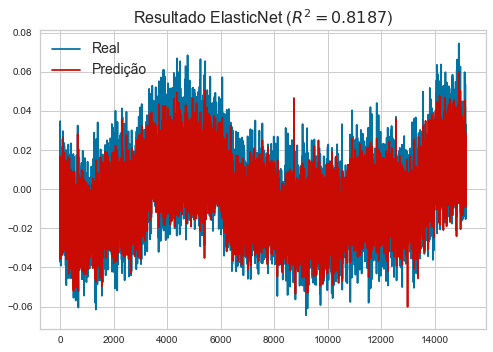

In [60]:
#Usando apenas ['CC_FL', 'CC_BL', 'AT_Y', 'AU_395_FR', 'AU_395_FL', 'AT_X', 'AT_Z']
plt.plot(real,'b',label='Real')
plt.plot(predito,'r',label = 'Predição')
plt.title('Resultado ElasticNet ($R^2=0.8187$)',size=16)
plt.legend(fontsize=14)

In [30]:
#residuals = real - predito

## Suport Vector Machine (SVM)

In [31]:
from sklearn.svm import SVR

def objective(trial):
    
        
    sv_gamma = trial.suggest_float("gamma", low=0.0001, high=1, step=0.001)
    sv_C= trial.suggest_float("C", low=0.001, high=100,step=0.05)
    sv_epsilon= trial.suggest_float("epsilon", low=0.001, high=1,step=0.01)
    
    #sv_kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
    
    model = SVR(gamma=sv_gamma,C=sv_C,epsilon=sv_epsilon)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
#study_svm = optuna.create_study(direction='maximize')

In [32]:
#study_svm.optimize(objective, n_trials=20,show_progress_bar=True)

#trial = study_svm.best_trial

#print('Accuracy: {}'.format(trial.value))
#print("Best hyperparameters: {}".format(trial.params))

In [33]:
#joblib.dump(study_svm, "study_SVM.pkl")

### AdaBoost

In [34]:
from sklearn.ensemble import AdaBoostRegressor

def objective(trial):
    
        
    h_n_estimators = trial.suggest_int("n_estimators", low=300, high=1000, step=25)
    h_learning_rate = trial.suggest_float("learning_rate", 0.1, 1)
    h_loss = trial.suggest_categorical("loss", ['linear', 'square', 'exponential'])
    
    model = AdaBoostRegressor(learning_rate=h_learning_rate,
                                       loss=h_loss,
                                       n_estimators=h_n_estimators,
                                       random_state=0)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_ab = optuna.create_study(direction='maximize')

[I 2022-12-05 11:50:38,694] A new study created in memory with name: no-name-00681f53-1455-45af-a2e5-afa3b43dba02


In [35]:
study_ab.optimize(objective, n_trials=25)

trial_ab = study_ab.best_trial

print('Accuracy: {}'.format(trial_ab.value))
print("Best hyperparameters: {}".format(trial_ab.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

[I 2022-12-05 11:51:26,170] Trial 0 finished with value: 0.6641285656847347 and parameters: {'n_estimators': 775, 'learning_rate': 0.5030210320550271, 'loss': 'exponential'}. Best is trial 0 with value: 0.6641285656847347.
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

[I 2022-12-05 11:52:14,537] Trial 1 finished with value: 0.6634206025025313 and parameters: {'n_estimators': 825, 'learning_rate': 0.9707928249087905, 'loss': 'exponential'}. Best is trial 0 with value: 0.6641285656847347.
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packa

Accuracy: 0.6939106895158585
Best hyperparameters: {'n_estimators': 750, 'learning_rate': 0.853555333188412, 'loss': 'square'}


In [36]:
joblib.dump(study_ab, "study_AdaBost_BL.pkl")

['study_AdaBost_BL.pkl']

In [37]:
optuna.visualization.plot_optimization_history(study_ab)

In [38]:
optuna.visualization.plot_slice(study_ab)

https://medium.com/analytics-vidhya/xgboost-colsample-by-hyperparameters-explained-6c0bac1bdc1

In [39]:
import xgboost as xgb

def objective(trial):
    
        
    #x_max_depth = trial.suggest_int("max_depth",2,20)
    #x_learning_rate = trial.suggest_float("learning_rate",0.01,0.1)
    #x_n_estimators = trial.suggest_int("n_estimators", low=50, high=600, step=10)
    #x_colsample_bytree = trial.suggest_float("bytree",0.1,0.9)
    #x_min_child_weight =  trial.suggest_int("min_child_weight",4,12)
    param = {
        'lambda': trial.suggest_loguniform('lambda',low=1e-3,high=5),
        'alpha': trial.suggest_loguniform('alpha', low=1e-3,high=5),
        'colsample_bytree': trial.suggest_float('colsample_bytree',low=0.3,high=1,step=0.1),
        'subsample': trial.suggest_float('subsample',0.1,1,step=0.1),
        'n_estimators': trial.suggest_int('n_estimators', 500, 10000, 25),
        'max_depth': trial.suggest_int('max_depth',2,20,2),
        'random_state': 2020,
        'min_split_loss': trial.suggest_loguniform('min_split_loss',low=1e-3,high=0.1),
        'min_child_weight': trial.suggest_float('min_child_weight',0.1,10,step=0.5),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel',0.3,1,step=0.1),
        'colsample_bynode': trial.suggest_float('colsample_bynode',0.3,1,step=0.1)
    }
    
    model = xgb.XGBRegressor(**param)  
    
    

   
    #model.fit(X_train_scaled,y_train)
    #p=model.predict(X_test_scaled)
    #score= r2_score(y_test,p)
    
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_xgbr= optuna.create_study(direction='maximize')

[I 2022-12-05 12:10:33,313] A new study created in memory with name: no-name-8f865db1-830f-4f56-a5ba-384c253a1e76


In [52]:
study_xgbr.optimize(objective, n_trials=10,show_progress_bar=True)

trial_xgbr= study_xgbr.best_trial

print('Accuracy: {}'.format(trial_xgbr.value))
print("Best hyperparameters: {}".format(trial_xgbr.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\distributions.py:668: UserWarning:

The distribution is specified by [0.1, 10] and step=0.5, but the range is not divisible by `step`. It will be replaced by [0.1, 9.6].



[I 2022-12-05 14:11:45,323] Trial 20 finished with value: 0.7510469631385304 and parameters: {'lambda': 0.5340462118205079, 'alpha': 0.042897005111015254, 'colsample_bytree': 0.5, 'subsample': 0.9, 'n_estimators': 8125, 'max_depth': 10, 'min_split_loss': 0.0075941352964310075, 'min_child_weight': 8.6, 'colsample_bylevel': 0.7, 'colsample_bynode': 0.4}. Best is trial 17 with value: 0.7897321698746215.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\distributions.py:668: UserWarning:

The distribution is specified by [0.1, 10] and step=0.5, but the range is not divisible by `step`. It will be replaced by [0.1, 9.6].



[I 2022-12-05 14:18:32,681] Trial 21 finished with value: 0.7730948526366761 and parameters: {'lambda': 0.06275281986152934, 'alpha': 0.6403739270677646, 'colsample_bytree': 0.5, 'subsample': 1.0, 'n_estimators': 9825, 'max_depth': 8, 'min_split_loss': 0.00160732815776334, 'min_child_weight': 8.1, 'colsample_bylevel': 0.6000000000000001, 'colsample_bynode': 0.8}. Best is trial 17 with value: 0.7897321698746215.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\distributions.py:668: UserWarning:

The distribution is specified by [0.1, 10] and step=0.5, but the range is not divisible by `step`. It will be replaced by [0.1, 9.6].



[I 2022-12-05 14:22:24,439] Trial 22 finished with value: 0.7693052063750238 and parameters: {'lambda': 0.04117543324801852, 'alpha': 1.2944236656687695, 'colsample_bytree': 0.4, 'subsample': 1.0, 'n_estimators': 7575, 'max_depth': 8, 'min_split_loss': 0.0010178502898842451, 'min_child_weight': 8.1, 'colsample_bylevel': 0.6000000000000001, 'colsample_bynode': 0.8}. Best is trial 17 with value: 0.7897321698746215.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\distributions.py:668: UserWarning:

The distribution is specified by [0.1, 10] and step=0.5, but the range is not divisible by `step`. It will be replaced by [0.1, 9.6].



[I 2022-12-05 14:26:22,545] Trial 23 finished with value: 0.7692883772410307 and parameters: {'lambda': 0.010471241100725878, 'alpha': 0.2678876575522937, 'colsample_bytree': 0.5, 'subsample': 0.9, 'n_estimators': 9100, 'max_depth': 4, 'min_split_loss': 0.0017095745151948063, 'min_child_weight': 9.1, 'colsample_bylevel': 0.9000000000000001, 'colsample_bynode': 0.9000000000000001}. Best is trial 17 with value: 0.7897321698746215.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\distributions.py:668: UserWarning:

The distribution is specified by [0.1, 10] and step=0.5, but the range is not divisible by `step`. It will be replaced by [0.1, 9.6].



[I 2022-12-05 14:30:32,992] Trial 24 finished with value: 0.7732852548328049 and parameters: {'lambda': 0.17610787254781593, 'alpha': 0.5040668571299776, 'colsample_bytree': 0.5, 'subsample': 0.7000000000000001, 'n_estimators': 5675, 'max_depth': 8, 'min_split_loss': 0.0026320504209207335, 'min_child_weight': 7.6, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.8}. Best is trial 17 with value: 0.7897321698746215.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\distributions.py:668: UserWarning:

The distribution is specified by [0.1, 10] and step=0.5, but the range is not divisible by `step`. It will be replaced by [0.1, 9.6].



[I 2022-12-05 14:39:48,863] Trial 25 finished with value: 0.7709292598625028 and parameters: {'lambda': 0.0030776690755321312, 'alpha': 0.12288670835156032, 'colsample_bytree': 0.4, 'subsample': 1.0, 'n_estimators': 8875, 'max_depth': 10, 'min_split_loss': 0.0014482619301529342, 'min_child_weight': 6.6, 'colsample_bylevel': 0.6000000000000001, 'colsample_bynode': 0.6000000000000001}. Best is trial 17 with value: 0.7897321698746215.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\distributions.py:668: UserWarning:

The distribution is specified by [0.1, 10] and step=0.5, but the range is not divisible by `step`. It will be replaced by [0.1, 9.6].



[I 2022-12-05 14:44:12,075] Trial 26 finished with value: 0.6995578633514428 and parameters: {'lambda': 0.9247515120395652, 'alpha': 1.4067997588169452, 'colsample_bytree': 0.7, 'subsample': 0.7000000000000001, 'n_estimators': 7100, 'max_depth': 6, 'min_split_loss': 0.018721171092622647, 'min_child_weight': 9.1, 'colsample_bylevel': 0.7, 'colsample_bynode': 0.9000000000000001}. Best is trial 17 with value: 0.7897321698746215.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\distributions.py:668: UserWarning:

The distribution is specified by [0.1, 10] and step=0.5, but the range is not divisible by `step`. It will be replaced by [0.1, 9.6].



[I 2022-12-05 14:48:09,487] Trial 27 finished with value: 0.7891271675868026 and parameters: {'lambda': 2.4861319296699844, 'alpha': 0.022077046941310637, 'colsample_bytree': 0.3, 'subsample': 0.8, 'n_estimators': 8725, 'max_depth': 4, 'min_split_loss': 0.003149421059473873, 'min_child_weight': 8.1, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.7}. Best is trial 17 with value: 0.7897321698746215.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\distributions.py:668: UserWarning:

The distribution is specified by [0.1, 10] and step=0.5, but the range is not divisible by `step`. It will be replaced by [0.1, 9.6].



[I 2022-12-05 14:52:02,009] Trial 28 finished with value: 0.7907854001588562 and parameters: {'lambda': 3.4314434224223884, 'alpha': 0.024201643977330607, 'colsample_bytree': 0.3, 'subsample': 0.8, 'n_estimators': 8625, 'max_depth': 4, 'min_split_loss': 0.003086821551748779, 'min_child_weight': 9.6, 'colsample_bylevel': 0.9000000000000001, 'colsample_bynode': 0.7}. Best is trial 28 with value: 0.7907854001588562.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\distributions.py:668: UserWarning:

The distribution is specified by [0.1, 10] and step=0.5, but the range is not divisible by `step`. It will be replaced by [0.1, 9.6].



[I 2022-12-05 14:55:46,285] Trial 29 finished with value: 0.7758587904497947 and parameters: {'lambda': 4.646660738348026, 'alpha': 0.02704766962765077, 'colsample_bytree': 0.3, 'subsample': 0.7000000000000001, 'n_estimators': 8600, 'max_depth': 4, 'min_split_loss': 0.003853986516831818, 'min_child_weight': 2.6, 'colsample_bylevel': 0.9000000000000001, 'colsample_bynode': 0.7}. Best is trial 28 with value: 0.7907854001588562.
Accuracy: 0.7907854001588562
Best hyperparameters: {'lambda': 3.4314434224223884, 'alpha': 0.024201643977330607, 'colsample_bytree': 0.3, 'subsample': 0.8, 'n_estimators': 8625, 'max_depth': 4, 'min_split_loss': 0.003086821551748779, 'min_child_weight': 9.6, 'colsample_bylevel': 0.9000000000000001, 'colsample_bynode': 0.7}


In [53]:
joblib.dump(study_xgbr, "study_XGBoost_BL.pkl")

['study_XGBoost_BL.pkl']

In [54]:
optuna.visualization.plot_optimization_history(study_xgbr)

In [55]:
optuna.visualization.plot_slice(study_xgbr)

In [44]:
#study = joblib.load("study_XGBoost.pkl")
#print("Best trial until now:")
#print(" Value: ", study.best_trial.value)
#print(" Params: ",study.best_params)

In [45]:
#import xgboost as xgb
#mdl = xgb.XGBRegressor(**study.best_params,random_state=2020)
#mdl.fit(X_train_scaled,y_train)
#p=mdl.predict(X_test_scaled)
#score= mean_squared_error(y_test,p)
#score_r2 = r2_score(y_test,p)
#print("RMSE: ", score)
#print("R2: ", score_r2)

In [46]:
#predito_XGB = np.array(p,dtype=float)
#real= np.array(y_test,dtype=float)


In [47]:
#residuals = real - predito

In [48]:
JLJLHHHJAJÇLÇLKÇLAKDÇ

NameError: name 'JLJLHHHJAJÇLÇLKÇLAKDÇ' is not defined

In [ ]:
sns.histplot(data=residuals,label='Resíduos')
plt.legend(fontsize=14)

In [ ]:
sns.boxplot(residuals)

Text(0.5, 1.0, 'Resultado XGBoost $R^2$ = 0.7740')

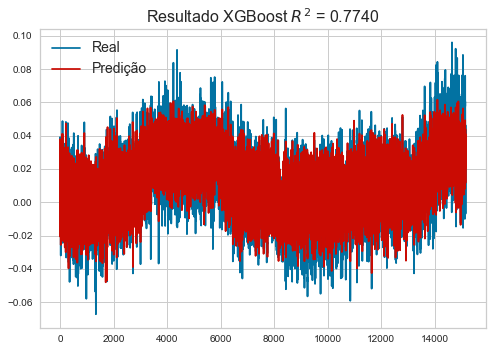

In [ ]:
plt.plot(real,'b',label='Real')
plt.plot(predito_XGB,'r',label = 'Predição')
plt.legend(fontsize=14)
plt.title('Resultado XGBoost $R^2$ = 0.7740',size=16)
#plt.xlim([9000,10000])
#plt.ylim([-0.05,0.1])
#RMSE:  0.0001065447461351567
#R2:  0.7738208762340173

In [ ]:
predicted_XGB = pd.DataFrame(p, columns = ['L/V_FR'])
predicted_XGB.to_csv(r'C:\Users\DELL\Desktop\PG\predito_xgboost.csv', index = False)
y_test.to_csv(r'C:\Users\DELL\Desktop\PG\teste_real.csv', index=False)

# Learning Curve

In [ ]:
plt.figure(figsize=(12,6))

from yellowbrick.model_selection import LearningCurve

# Load a regression dataset

# Instantiate the regression model and visualizer
#model = ElasticNet(**study_en.best_params,random_state=2020)
#visualizer = LearningCurve(model, scoring='r2')

#visualizer.fit(X_train_scaled, y_train)        # Fit the data to the visualizer
#visualizer.show()           # Finalize and render the figure

<Figure size 864x432 with 0 Axes>

# Real intrumantation IRV

In [61]:
X_IRV, y_IRV = df[['CC_FR', 'CC_FL', 'CC_BR', 'CC_BL','AT_Y',
'AU_FR','AU_FL','AU_BR','AU_BL','AT_X','AT_Z']], df[['L/V_BL']]
X_train_IRV,X_test_IRV,y_train_IRV,y_test_IRV = create_scaled_dataset(X_IRV,y_IRV)

All models for determining feature importance
[Lasso(alpha=0.001), RandomForestRegressor(max_depth=36, max_features=5, min_samples_leaf=5,
                      min_samples_split=11, n_estimators=375,
                      random_state=2020), XGBRegressor(alpha=0.02111400159780091, base_score=None, booster=None,
             colsample_bylevel=0.9000000000000001, colsample_bynode=1.0,
             colsample_bytree=0.6000000000000001, enable_categorical=False,
             gamma=None, gpu_id=None, importance_type=None,
             interaction_constraints=None, lambda=0.001530808845481313,
             learning_rate=None, max_delta_step=None, max_depth=10,
             min_child_weight=7.1, min_split_loss=0.0027632330369892592,
             missing=nan, monotone_constraints=None, n_estimators=5850,
             n_jobs=None, num_parallel_tree=None, predictor=None,
             random_state=2020, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.7000000000000

 17%|█▋        | 1/6 [00:00<00:00,  7.65it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\1229660262.py:150: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

 50%|█████     | 3/6 [10:39<13:57, 279.20s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

 67%|██████▋   | 4/6 [11:02<05:55, 177.84s/it]C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\1229660262.py:150: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

100%|██████████| 6/6 [11:12<00:00, 112.03s/it]
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature 

R2 score calculated
Obtaining feature importance - 0%
Obtaining feature importance - 50%
Obtaining feature importance - 100%


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but ElasticNet was fitted with feature names



CPU times: total: 30min 58s
Wall time: 11min 17s


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

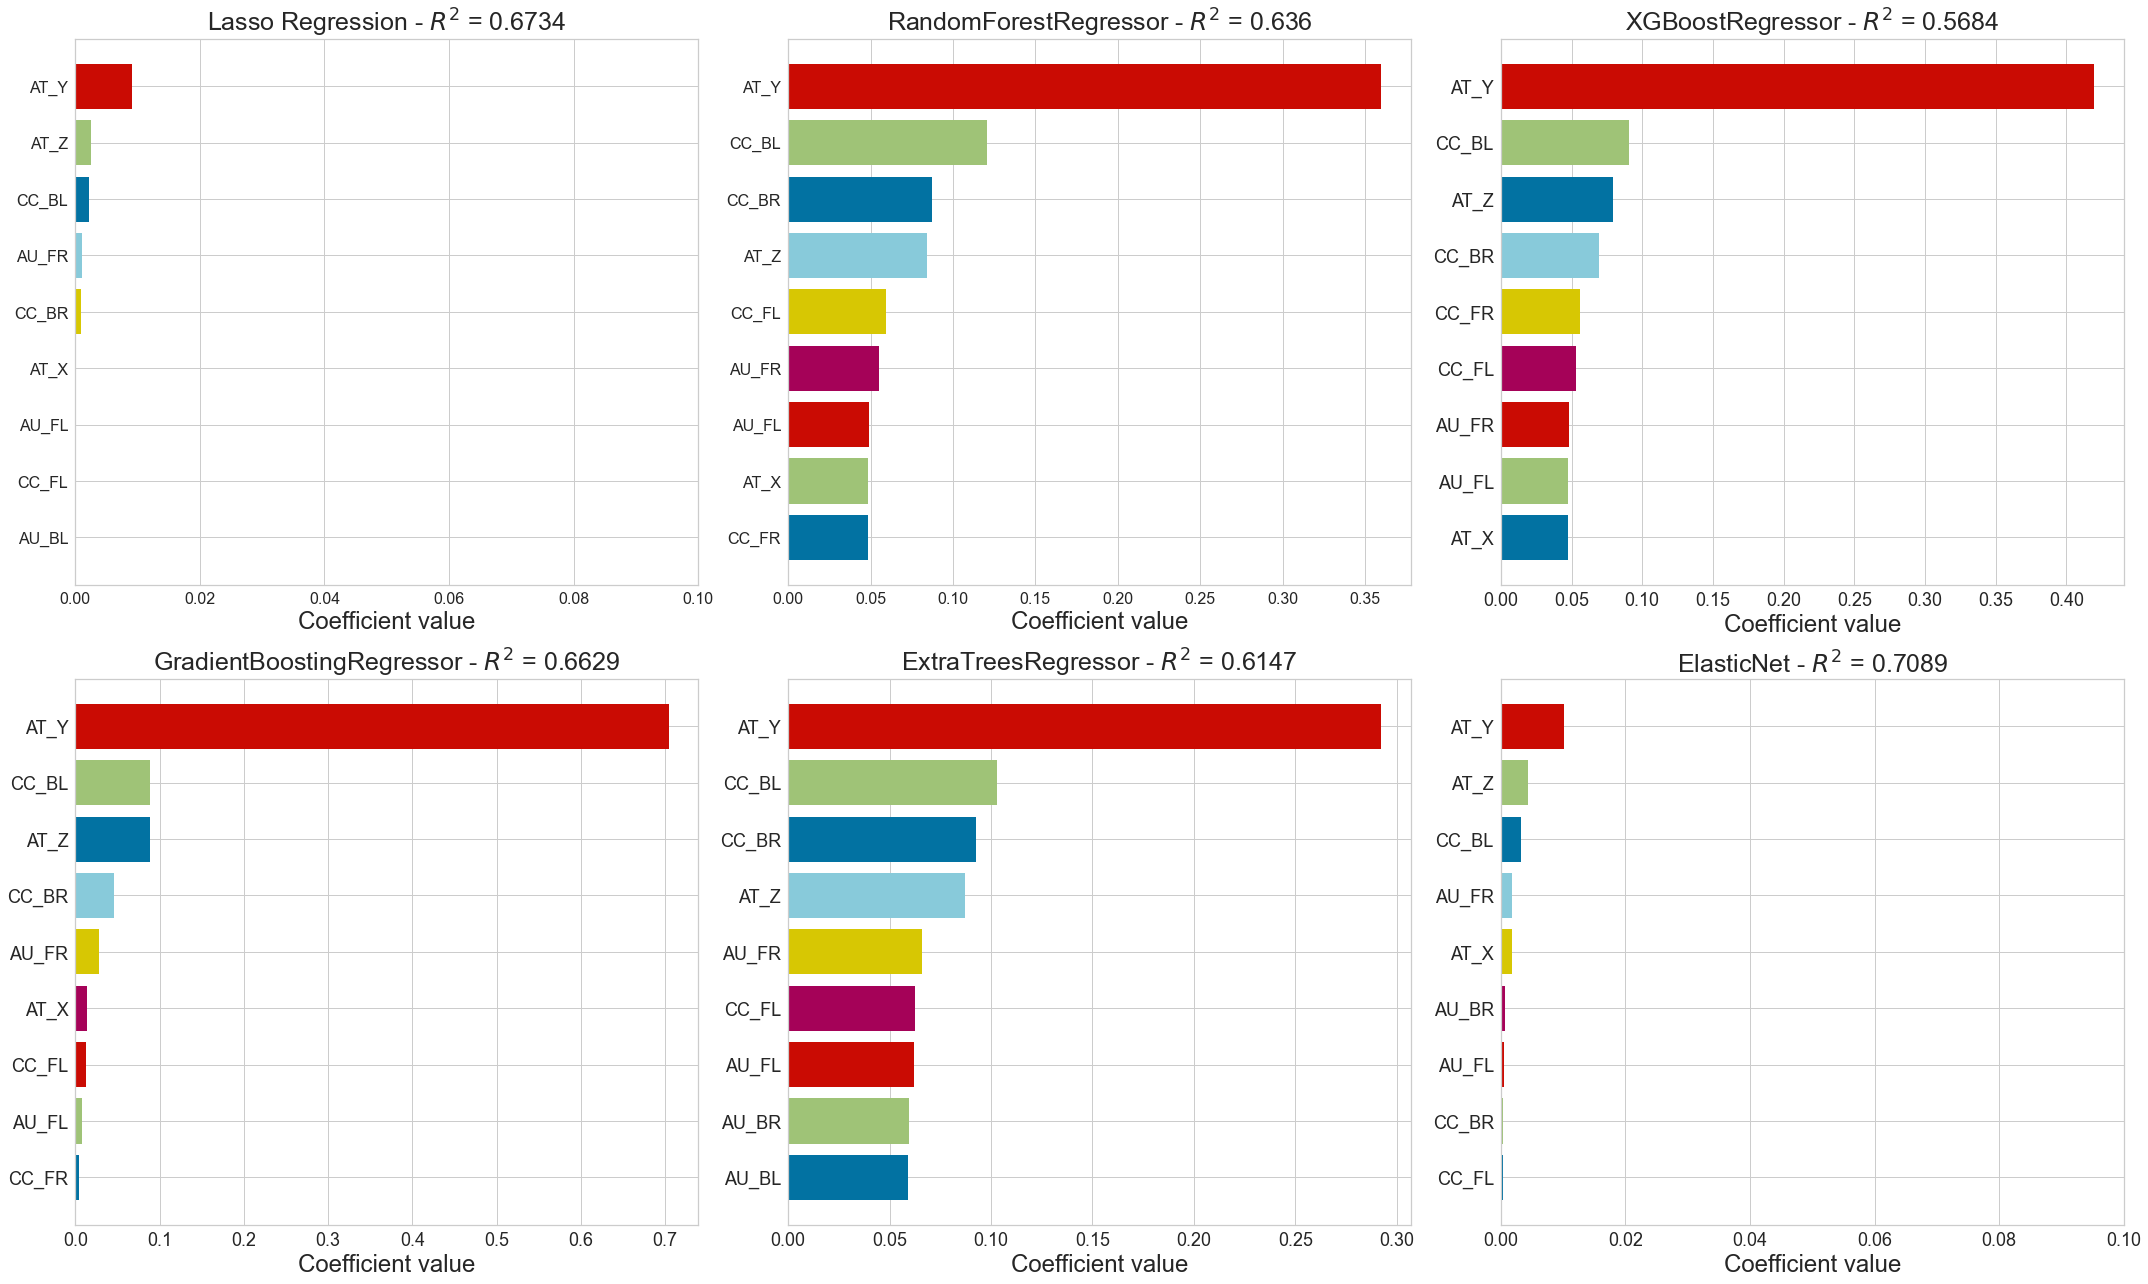

In [62]:
%%time
multi_select = multivariate_importance(X_train_IRV,X_test_IRV,y_train_IRV,y_test_IRV)     
multi_select.plot(relative=False)
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

np.seterr(divide='ignore')

In [63]:
X_IRV, y_IRV2 = df[['CC_FR', 'CC_FL', 'CC_BR', 'CC_BL','AT_Y',
'AU_FR','AU_FL','AU_BR','AU_BL','AT_X','AT_Z']], df[['L/V_BR']]
X_train_IRV,X_test_IRV,y_train_IRV2,y_test_IRV2 = create_scaled_dataset(X_IRV,y_IRV2)

In [64]:
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import numpy as np
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from yellowbrick.model_selection import feature_importances
import xgboost as xgb
from sklearn.linear_model import ElasticNet
import eli5
from tqdm import tqdm
from eli5.sklearn import PermutationImportance



def summary_plot(model,X_train,y_train,X_test,y_test,cv,train_sizes=np.linspace(0.1,1.0,5),lc=False):

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
    plt.rc('legend',fontsize=12.5) 


    visualize_residuals = residuals_plot(model,X_train, y_train, X_test, y_test,show=False,ax=ax[0],title=' ');
    ax[0].tick_params(labelsize=13)
    ax[0].set_xlabel('Predicted value (mm)',fontsize=16)
    ax[0].set_ylabel('Residuals (mm)',fontsize=16)

    visualizer = prediction_error(model, X_test, y_test, show=False, ax=ax[1], title=' ')
    ax[1].tick_params(labelsize=13)
    ax[1].set_xlabel('Predicted value (mm)',fontsize=16)
    ax[1].set_ylabel('Real value (mm)',fontsize=16)

    if lc:
        print('Plotting learning curves')
        visual_LC = learning_curve(model, X_train, y_train,scoring='r2',cv=cv,ax=ax[2],title=' ',show=False,train_sizes=train_sizes,n_jobs=-1);
        ax[2].set_ylim([0.6, 1.05])
        ax[2].tick_params(labelsize=13)
        ax[2].set_xlabel('Number of training instances',fontsize=16)
        ax[2].set_ylabel(r'$R^2$' + ' metric',fontsize=16)
        
    plt.show()
    
    return


def metrics(y_test,predict):
    
    mse = mean_squared_error(y_test,predict)
    mae= mean_absolute_error(y_test,predict)
    r2= r2_score(y_test,predict)
    return print("MSE:{}".format(mse),"\nMAE:{}".format(mae),"\nR2:{}".format(r2))


def feature_importance(X_train,y_train,X_test,y_test,relative=True,topn=11):
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10),sharex=True)
    plt.rc('legend',fontsize=12.5) 

    ################################################################
    # Lasso Regression
    ################################################################
    
    mod = Lasso(alpha=0.001)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    viz1 = FeatureImportances(Lasso(alpha=0.001),relative=relative,topn=topn, title =' ',ax=ax[0,0],absolute=True)
    viz1.fit(X_train,y_train)
    ax[0,0].tick_params(labelsize=13)
    ax[0,0].set_title('Lasso Regression - R^2 = {}'.format(r2),fontsize=20)

    ################################################################

    mod = RandomForestRegressor(**study_rf.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    rfr = RandomForestRegressor(**study_rf.best_params,random_state=2020)
    viz2 = FeatureImportances(rfr,relative=relative, topn=topn, title =' ',ax=ax[0,1])
    viz2.fit(X_train,y_train)
    ax[0,1].tick_params(labelsize=13)
    ax[0,1].set_title('RandomForestRegressor - R^2 = {}'.format(r2),fontsize=20)
    
    ################################################################

    mod = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    abr = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
    viz3 = FeatureImportances(abr,relative=relative, topn=topn, title =' ', ax=ax[1,0])
    viz3.fit(X_train,y_train)
    ax[1,0].tick_params(labelsize=13)
    ax[1,0].set_xlabel('Relative feature importance',fontsize=16)
    ax[1,0].set_title('XGBoostRegressor - R^2 = {}'.format(r2),fontsize=20)
  
    ################################################################
    
    mod = ElasticNet(**study_en.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    gbr = ElasticNet(**study_en.best_params,random_state=2020)
    viz4 = FeatureImportances(gbr,relative=relative, topn=topn, title =' ',ax=ax[1,1])
    viz4.fit(X_train,y_train)
    ax[1,1].tick_params(labelsize=13)
    ax[1,1].set_xlabel('Relative feature importance',fontsize=16)
    ax[1,1].set_title('ElasticNet - R^2 = {}'.format(r2),fontsize=20)

    plt.tight_layout()
    plt.show()
    
    return


class multivariate_importance():
    def __init__(self, X_train, X_test, y_train, y_test, nmodels=6):

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.nmodels = nmodels

        mod1 = Lasso(alpha=0.001)
        mod2 = RandomForestRegressor(**study_rf.best_params,random_state=2020)
        mod3 = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
        mod4 = GradientBoostingRegressor(random_state=0)
        mod5 = ExtraTreesRegressor(random_state=0, n_jobs=-1)
        mod6 = ElasticNet(**study_en.best_params,random_state=2020)

        self.mod_list = [mod1, mod2,
                         mod3, mod4,
                         mod5, mod6]

        self.mod_list = self.mod_list[0:self.nmodels]

        self.model_r2 = None

        print('All models for determining feature importance')
        print(self.mod_list)
        print('')

    def train_models(self):

        model_r2 = []
        for model in tqdm(self.mod_list):
            model.fit(self.X_train, self.y_train)
            model_r2.append(np.round(r2_score(self.y_test, model.predict(self.X_test)), 4))

        self.model_r2 = model_r2

        return model_r2

    def permutation_importance(self, model_index=1):

        self.mod_list[model_index].fit(self.X_train, self.y_train)
        perm = PermutationImportance(self.mod_list[model_index], random_state=1).fit(
            self.X_train, self.y_train)
        return eli5.show_weights(perm, feature_names=X_train.columns.tolist())

    def plot(self, relative=True, topn=11, absolute=True, plot_R2=True):

        fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 18))

        if self.model_r2 == None:
            print('Obtaining R2 score for all 6 models')
            multivariate_importance.train_models(self)
            print('R2 score calculated')

        print('Obtaining feature importance - 0%')
        viz1 = FeatureImportances(self.mod_list[0], relative=relative, topn=topn, ax=ax[0, 0], absolute=absolute)
        viz1.fit(self.X_train, self.y_train)
        ax[0, 0].tick_params(labelsize=16)

        viz2 = FeatureImportances(self.mod_list[1], relative=relative, topn=topn, ax=ax[0, 1], absolute=absolute)
        viz2.fit(self.X_train, self.y_train)
        ax[0, 1].tick_params(labelsize=16)

        viz3 = FeatureImportances(self.mod_list[2], relative=relative, topn=topn, ax=ax[0, 2], absolute=absolute)
        viz3.fit(self.X_train, self.y_train)
        ax[0, 2].tick_params(labelsize=18)
        print('Obtaining feature importance - 50%')
        viz4 = FeatureImportances(self.mod_list[3], relative=relative, topn=topn, ax=ax[1, 0], absolute=absolute)
        viz4.fit(self.X_train, self.y_train)
        ax[1, 0].tick_params(labelsize=18)

        viz5 = FeatureImportances(self.mod_list[4], relative=relative, topn=topn, ax=ax[1, 1], absolute=absolute)
        viz5.fit(self.X_train, self.y_train)
        ax[1, 1].tick_params(labelsize=18)

        viz6 = FeatureImportances(self.mod_list[5], relative=relative, topn=topn, ax=ax[1, 2], absolute=absolute)
        viz6.fit(self.X_train, self.y_train)
        ax[1, 2].tick_params(labelsize=18)
        print('Obtaining feature importance - 100%')

        if plot_R2:

            ax[0, 0].set_title(
                'Lasso Regression - $R^2$ = {}'.format(self.model_r2[0]), fontsize=25)
            ax[0, 1].set_title(
                'RandomForestRegressor - $R^2$ = {}'.format(self.model_r2[1]), fontsize=25)
            ax[0, 2].set_title(
                'XGBoostRegressor - $R^2$ = {}'.format(self.model_r2[2]), fontsize=25)
            ax[1, 0].set_title(
                'GradientBoostingRegressor - $R^2$ = {}'.format(self.model_r2[3]), fontsize=25)
            ax[1, 1].set_title(
                'ExtraTreesRegressor - $R^2$ = {}'.format(self.model_r2[4]), fontsize=25)
            ax[1, 2].set_title(
                'ElasticNet - $R^2$ = {}'.format(self.model_r2[5]), fontsize=25)

            ax[0, 0].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 1].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 2].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 0].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 1].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 2].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 0].set_xlim([0,0.1])
            #ax[0, 1].set_xlim([0,0.5])
            #ax[0, 2].set_xlim([0,0.5])
            #ax[1, 0].set_xlim([0,0.5])
            #ax[1, 1].set_xlim([0,0.5])
            ax[1, 2].set_xlim([0,0.1])

        plt.tight_layout()
        return


All models for determining feature importance
[Lasso(alpha=0.001), RandomForestRegressor(max_depth=36, max_features=5, min_samples_leaf=5,
                      min_samples_split=11, n_estimators=375,
                      random_state=2020), XGBRegressor(alpha=0.02111400159780091, base_score=None, booster=None,
             colsample_bylevel=0.9000000000000001, colsample_bynode=1.0,
             colsample_bytree=0.6000000000000001, enable_categorical=False,
             gamma=None, gpu_id=None, importance_type=None,
             interaction_constraints=None, lambda=0.001530808845481313,
             learning_rate=None, max_delta_step=None, max_depth=10,
             min_child_weight=7.1, min_split_loss=0.0027632330369892592,
             missing=nan, monotone_constraints=None, n_estimators=5850,
             n_jobs=None, num_parallel_tree=None, predictor=None,
             random_state=2020, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.7000000000000

 17%|█▋        | 1/6 [00:00<00:00,  9.47it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\452399402.py:150: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

 50%|█████     | 3/6 [13:19<17:03, 341.27s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

 67%|██████▋   | 4/6 [13:47<07:15, 217.65s/it]C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\452399402.py:150: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

100%|██████████| 6/6 [13:58<00:00, 139.82s/it]
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature na

R2 score calculated
Obtaining feature importance - 0%
Obtaining feature importance - 50%
Obtaining feature importance - 100%


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but ElasticNet was fitted with feature names



CPU times: total: 32min 11s
Wall time: 14min 1s


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

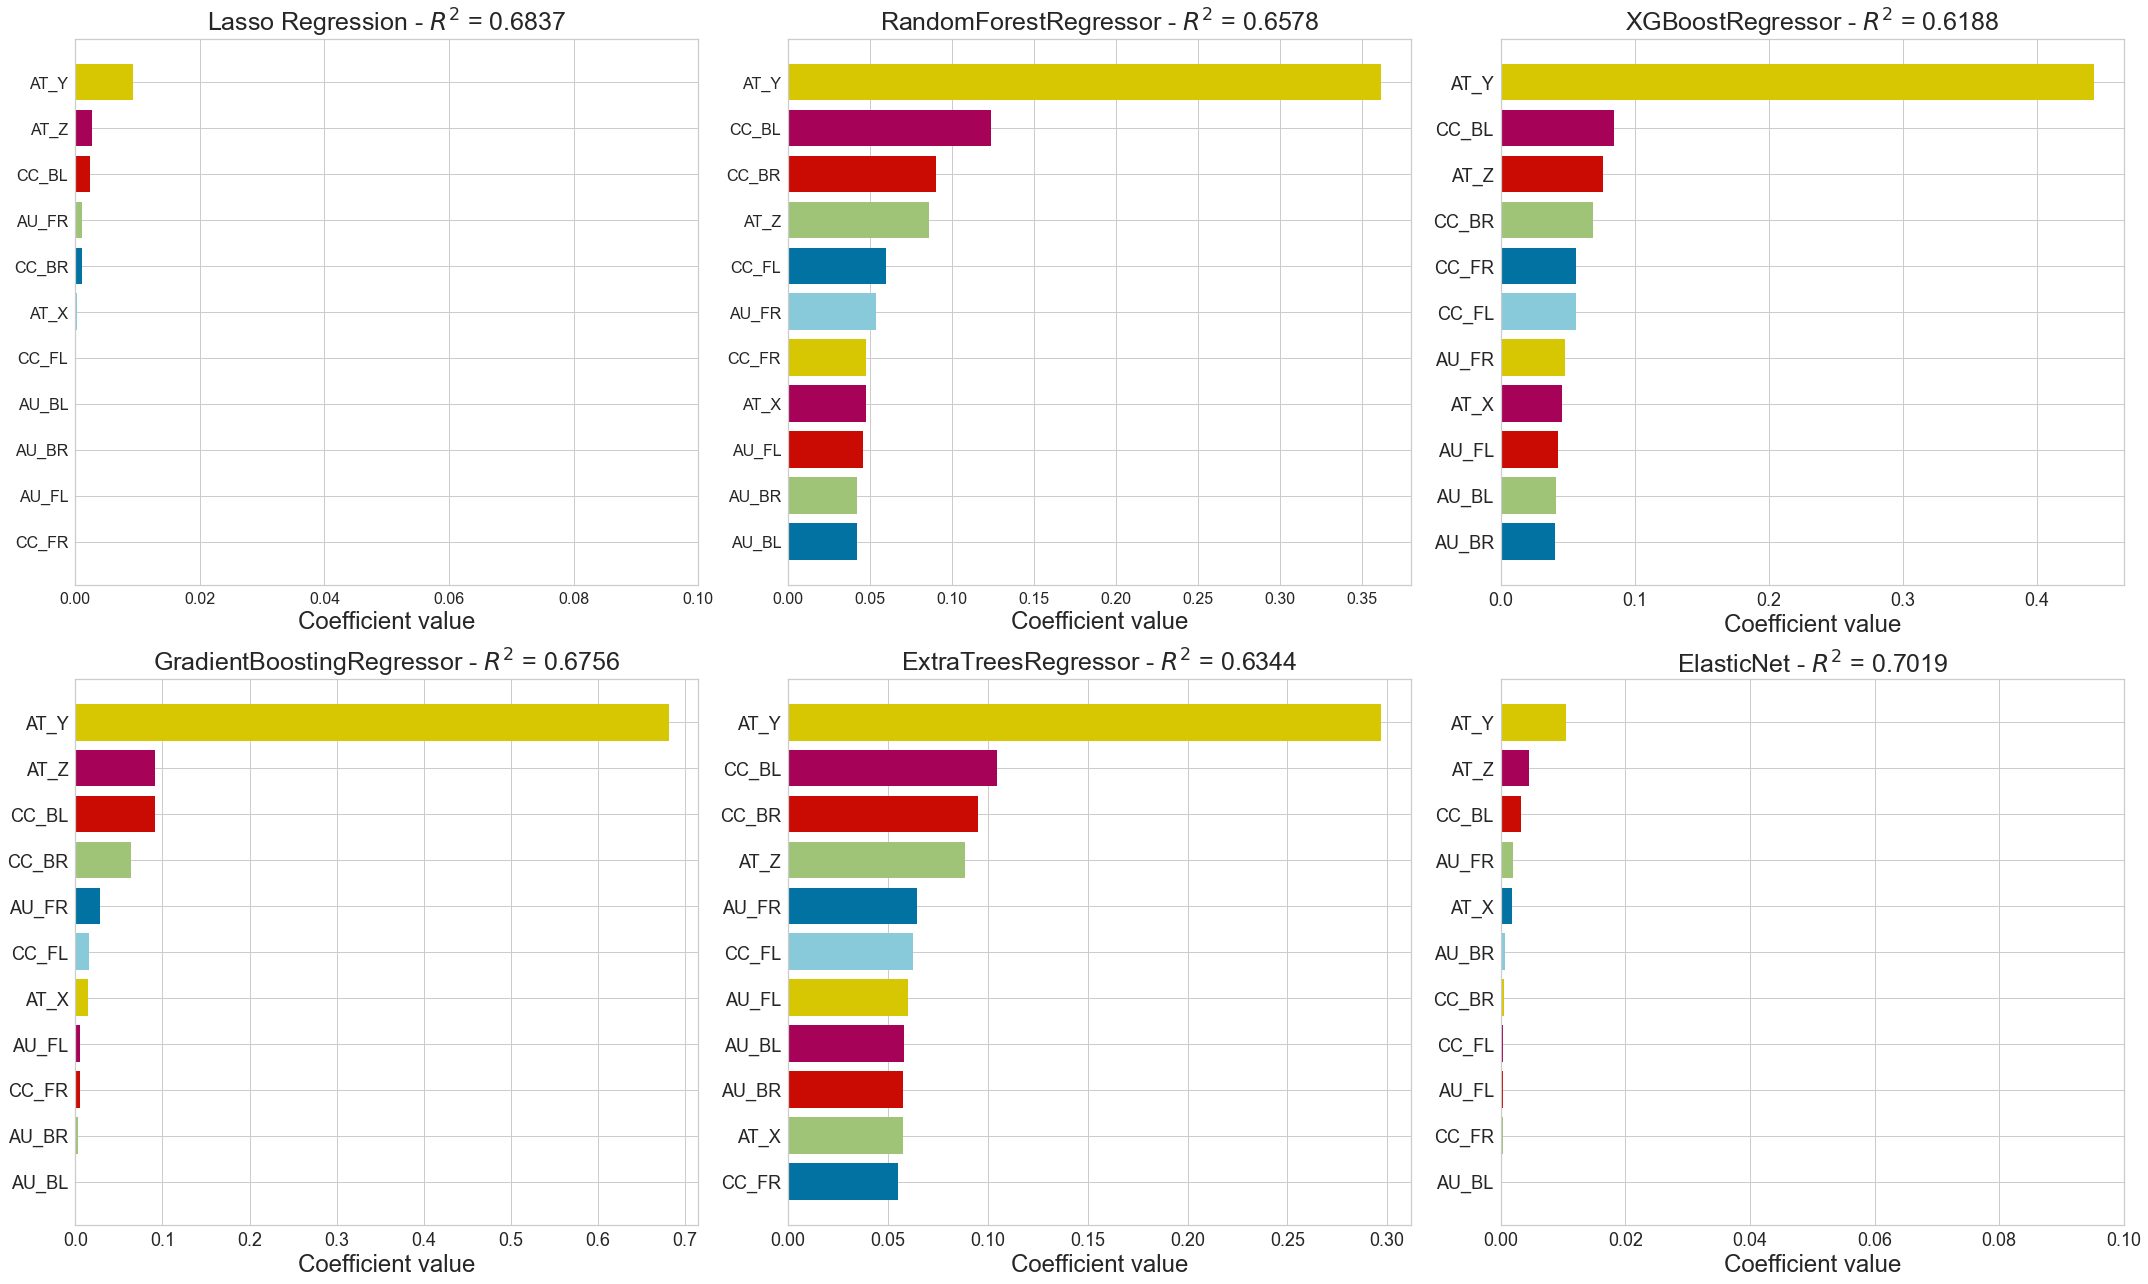

In [65]:
%%time
multi_select = multivariate_importance(X_train_IRV,X_test_IRV,y_train_IRV2,y_test_IRV2)     
multi_select.plot(relative=False)
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

np.seterr(divide='ignore')

All models for determining feature importance
[Lasso(alpha=0.001), RandomForestRegressor(max_depth=32, max_features=6, min_samples_leaf=6,
                      min_samples_split=4, n_estimators=330, random_state=2020), XGBRegressor(alpha=0.02111400159780091, base_score=None, booster=None,
             colsample_bylevel=0.9000000000000001, colsample_bynode=1.0,
             colsample_bytree=0.6000000000000001, enable_categorical=False,
             gamma=None, gpu_id=None, importance_type=None,
             interaction_constraints=None, lambda=0.001530808845481313,
             learning_rate=None, max_delta_step=None, max_depth=10,
             min_child_weight=7.1, min_split_loss=0.0027632330369892592,
             missing=nan, monotone_constraints=None, n_estimators=5850,
             n_jobs=None, num_parallel_tree=None, predictor=None,
             random_state=2020, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.7000000000000001,
             tree_

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_6004\452399402.py:150: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

 33%|███▎      | 2/6 [01:25<02:51, 42.94s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

 50%|█████     | 3/6 [09:30<11:20, 226.97s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

 67%|██████▋   | 4/6 [09:51<05:00, 150.22s/it]C:\Users\DELL\AppData\Local\Temp\ipykernel_6004\452399402.py:150: DataConversionWarning:

A column-vector y was passed when 

R2 score calculated
Obtaining feature importance - 0%
Obtaining feature importance - 50%


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but ElasticNet was fitted with feature names



Obtaining feature importance - 100%
CPU times: total: 30min 19s
Wall time: 10min 1s


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

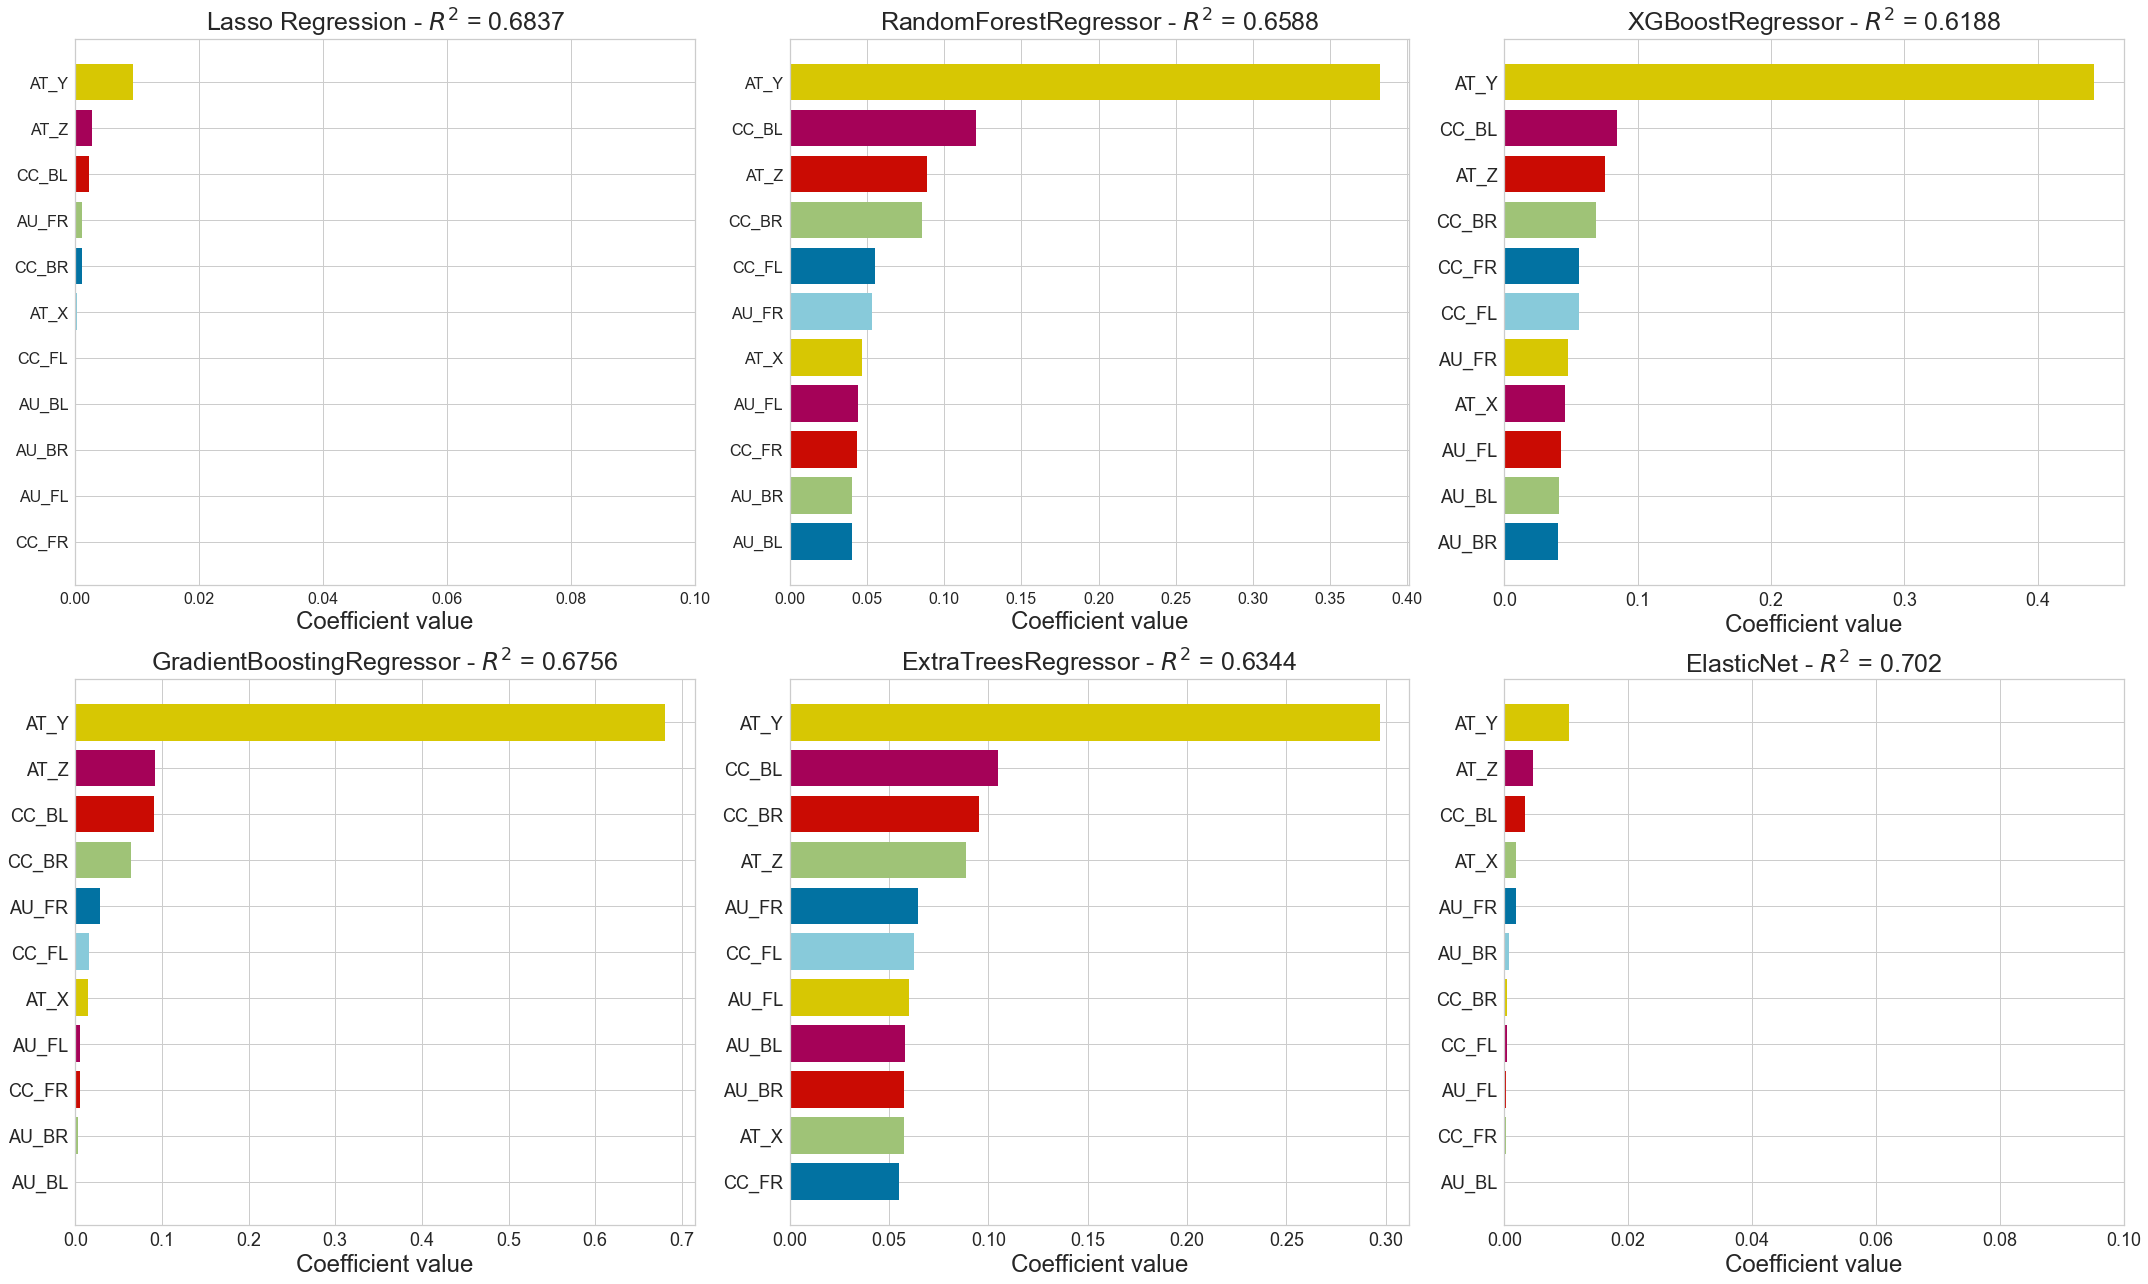

In [ ]:
%%time
multi_select = multivariate_importance(X_train_IRV,X_test_IRV,y_train_IRV2,y_test_IRV2)     
multi_select.plot(relative=False)
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

np.seterr(divide='ignore')